**[OCE-01]** 必要なモジュールをインポートして、乱数のシードを設定します。

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cPickle as pickle

np.random.seed(20160622)
tf.set_random_seed(20160622)

**[OCE-02]** データファイル「ORENIST.data」から画像とラベルのデータを読み込みます。

In [2]:
with open('ORENIST.data', 'rb') as file:
    images, labels = pickle.load(file)

**[OCE-03]** フィルターの情報を格納した多次元リストを作る関数を用意します。

In [3]:
def edge_filter():
    filter0 = np.array(
            [[ 2, 1, 0,-1,-2],
             [ 3, 2, 0,-2,-3],
             [ 4, 3, 0,-3,-4],
             [ 3, 2, 0,-2,-3],
             [ 2, 1, 0,-1,-2]]) / 23.0
    filter1 = np.array(
            [[ 2, 3, 4, 3, 2],
             [ 1, 2, 3, 2, 1],
             [ 0, 0, 0, 0, 0],
             [-1,-2,-3,-2,-1],
             [-2,-3,-4,-3,-2]]) / 23.0
    
    filter_array = np.zeros([5,5,1,2])
    filter_array[:,:,0,0] = filter0
    filter_array[:,:,0,1] = filter1

    return tf.constant(filter_array, dtype=tf.float32)

**[OCE-04]** 画像データにフィルターとプーリング層を適用する計算式を用意します。

In [4]:
x = tf.placeholder(tf.float32, [None, 784])
x_image = tf.reshape(x, [-1,28,28,1])

W_conv = edge_filter()
h_conv = tf.abs(tf.nn.conv2d(x_image, W_conv,
                             strides=[1,1,1,1], padding='SAME'))
h_conv_cutoff = tf.nn.relu(h_conv-0.2)

h_pool =tf.nn.max_pool(h_conv_cutoff, ksize=[1,2,2,1],
                       strides=[1,2,2,1], padding='SAME')

**[OCE-05]** プーリング層からの出力を全結合層とソフトマックス関数からなる「拡張された出力層」に入力する計算式を用意します。

In [5]:
h_pool_flat = tf.reshape(h_pool, [-1, 392])

num_units1 = 392
num_units2 = 2

w2 = tf.Variable(tf.truncated_normal([num_units1, num_units2]))
b2 = tf.Variable(tf.zeros([1, num_units2]))
hidden2 = tf.nn.tanh(tf.matmul(h_pool_flat, w2) + b2)

w0 = tf.Variable(tf.zeros([num_units2, 3]))
b0 = tf.Variable(tf.zeros([3]))
p = tf.nn.softmax(tf.matmul(hidden2, w0) + b0)

**[OCE-06]** 誤差関数 loss、トレーニングアルゴリズム train_step、正解率 accuracy を定義します。

In [6]:
t = tf.placeholder(tf.float32, [None, 3])
loss = -tf.reduce_sum(t * tf.log(p))
train_step = tf.train.AdamOptimizer().minimize(loss)
correct_prediction = tf.equal(tf.argmax(p, 1), tf.argmax(t, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

**[OCE-07]** セッションを用意して、Variable を初期化します。

In [7]:
sess = tf.InteractiveSession()
sess.run(tf.initialize_all_variables())

**[OCE-08]** パラメーターの最適化を200回繰り返します。

約100回の繰り返しで、100%の正解率を達成します。

In [8]:
i = 0
for _ in range(200):
    i += 1
    sess.run(train_step, feed_dict={x:images, t:labels})
    if i % 10 == 0:
        loss_val, acc_val = sess.run(
            [loss, accuracy], feed_dict={x:images, t:labels})
        print ('Step: %d, Loss: %f, Accuracy: %f'
               % (i, loss_val, acc_val))

Step: 10, Loss: 98.708427, Accuracy: 0.500000
Step: 20, Loss: 98.366470, Accuracy: 0.588889
Step: 30, Loss: 97.678238, Accuracy: 0.644444
Step: 40, Loss: 96.413132, Accuracy: 0.777778
Step: 50, Loss: 94.404045, Accuracy: 0.822222
Step: 60, Loss: 91.659653, Accuracy: 0.922222
Step: 70, Loss: 88.319672, Accuracy: 0.966667
Step: 80, Loss: 84.842911, Accuracy: 0.988889
Step: 90, Loss: 81.823654, Accuracy: 0.988889
Step: 100, Loss: 79.325333, Accuracy: 1.000000
Step: 110, Loss: 77.170593, Accuracy: 1.000000
Step: 120, Loss: 75.239372, Accuracy: 1.000000
Step: 130, Loss: 73.464691, Accuracy: 1.000000
Step: 140, Loss: 71.808243, Accuracy: 1.000000
Step: 150, Loss: 70.246765, Accuracy: 1.000000
Step: 160, Loss: 68.764801, Accuracy: 1.000000
Step: 170, Loss: 67.351250, Accuracy: 1.000000
Step: 180, Loss: 65.997833, Accuracy: 1.000000
Step: 190, Loss: 64.698051, Accuracy: 1.000000
Step: 200, Loss: 63.446754, Accuracy: 1.000000


**[OCE-09]** それぞれのデータの特徴変数 (z1, z2) を散布図に示します。

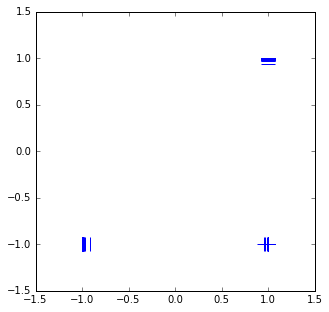

In [9]:
hidden2_vals = sess.run(hidden2, feed_dict={x:images})

z1_vals = [[],[],[]]
z2_vals = [[],[],[]]

for hidden2_val, label in zip(hidden2_vals, labels):
    label_num = np.argmax(label)
    z1_vals[label_num].append(hidden2_val[0])
    z2_vals[label_num].append(hidden2_val[1])
    
fig = plt.figure(figsize=(5,5))
subplot = fig.add_subplot(1,1,1)
subplot.scatter(z1_vals[0], z2_vals[0], s=200, marker='|')
subplot.scatter(z1_vals[1], z2_vals[1], s=200, marker='_')
subplot.scatter(z1_vals[2], z2_vals[2], s=200, marker='+')